# Classificação por Floresta Aleatória (Random Forest)

A classificação por floresta aleatória é uma técnica de aprendizado de máquina que combina o poder da aleatoriedade com o poder da média para construir um modelo robusto de classificação. Ela opera criando múltiplas árvores de decisão durante o treinamento e fazendo previsões com base na maioria das previsões das árvores individuais.

## Principais Características:
- **Árvores de Decisão:** Cada árvore na floresta é construída a partir de uma amostra aleatória do conjunto de dados de treinamento. Isso ajuda a reduzir a correlação entre as árvores individuais, tornando o modelo mais robusto.

- **Amostragem Aleatória de Características:** Durante a construção de cada árvore, apenas um subconjunto aleatório das características é considerado para dividir em cada nó da árvore. Isso introduz mais diversidade nas árvores e reduz a probabilidade de overfitting.

- **Votação por Maioria:** Ao fazer previsões, cada árvore na floresta contribui com uma votação para determinar a classe final de um exemplo. A classe mais frequente entre todas as árvores é escolhida como a previsão final.

## Vantagens:
- **Robustez:** Averiguando várias árvores de decisão, o modelo é menos propenso a overfitting e tem uma melhor capacidade de generalização em dados de teste.

- **Manuseio de Dados Não Lineares e de Alta Dimensão:** Pode lidar eficazmente com conjuntos de dados com muitas características e interações complexas entre elas.

- **Fácil de Usar:** Requer pouca ou nenhuma sintonia de parâmetros e lida bem com dados ausentes.

## Limitações:
- **Interpretabilidade:** Às vezes, a floresta aleatória pode ser difícil de interpretar em comparação com modelos lineares simples.

- **Desempenho em Dados Escaláveis:** Para conjuntos de dados muito grandes, o treinamento de uma floresta aleatória pode se tornar computacionalmente caro.

## Aplicações:
- **Classificação:** Prever a classe de um exemplo com base em suas características.

A implementação da classificação por floresta aleatória no scikit-learn, utilizando RandomForestClassifier, oferece uma interface simples e poderosa para treinar e fazer previsões com este modelo.

Importando bibliotecas

In [1]:
import gsidiag as gd
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import csv
import numpy as np

In [2]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics._plot.precision_recall_curve import PrecisionRecallDisplay
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.preprocessing import label_binarize
from sklearn.metrics import accuracy_score


from itertools import combinations
from itertools import cycle
import seaborn as sns



Definindo parâmetros para o uso do readDiag

In [3]:
DIRdiag = "/home/patrick/readDiag/data"

varName = "amsua"
varType = "n15"
dateIni="2020010100" 
dateFin="2020010106" 
nHour = "6"          
vminOMA = -2.0       
vmaxOMA = 2.0        
vminSTD = 0.0        
vmaxSTD = 14.0       
Level = 1000
Lay = None           
SingleL = "All" 

datei = datetime.strptime(str(dateIni), "%Y%m%d%H")
datef = datetime.strptime(str(dateFin), "%Y%m%d%H")
dates = [dates.strftime('%Y%m%d%H') for dates in pd.date_range(datei, datef,freq="6H").tolist()]

print(dates)


['2020010100', '2020010106']


Encontrando e listando arquivos para serem usados

In [4]:
paths, pathsc = [], []

OuterL = "01"        
[paths.append(DIRdiag+"/"+dt+"/diag_amsua_n15_"+OuterL+"."+dt) for dt in dates]

OuterLc = "03"
[pathsc.append(DIRdiag+"/"+dt+"/diag_amsua_n15_"+OuterLc+"."+dt) for dt in dates]

print(paths)
print("")
print(pathsc)

['/home/patrick/readDiag/data/2020010100/diag_amsua_n15_01.2020010100', '/home/patrick/readDiag/data/2020010106/diag_amsua_n15_01.2020010106']

['/home/patrick/readDiag/data/2020010100/diag_amsua_n15_03.2020010100', '/home/patrick/readDiag/data/2020010106/diag_amsua_n15_03.2020010106']


Definição da função para discretizar os dados de impacto:

In [5]:
# Função que retorna a categoria:
def categoria_de(valorRF):
    categoria = None
    if valorRF <= -0.25:
        categoria = "Impacto negativo alto"
    elif valorRF > -0.25 and valorRF < 0:
        categoria = "Impacto negativo baixo"
    elif valorRF == 0:
        categoria = "Impacto neutro"
    elif valorRF > 0 and valorRF < 0.25:
        categoria = "Impacto positivo baixo"
    elif valorRF >= 0.25:
        categoria = "Impacto positivo alto"
    return categoria

In [6]:
def MatrizConfusao(YTEST, YPRED, CLASSES, TIPO):
    # Computa a matriz de confusão
    matriz_confusao = confusion_matrix(YTEST, YPRED)

    # Imprime a matriz de confusão
    print(f"Matriz de Confusão para {TIPO}:")
    print(matriz_confusao)

    # Calcula a soma de cada linha da matriz de confusão
    sum_by_class = np.sum(matriz_confusao, axis=1)

    # Normaliza a matriz de confusão
    matriz_confusao_normalized = matriz_confusao / sum_by_class[:, np.newaxis]

    # Plota a matriz de confusão normalizada
    plt.figure(figsize=(8, 6))
    sns.heatmap(matriz_confusao_normalized, annot=True, fmt=".3f", 
                cmap="Blues", xticklabels=CLASSES, yticklabels=CLASSES)
    plt.title(f"Matriz de Confusão - {TIPO}")
    plt.xlabel("Valor Previsto")
    plt.ylabel("Valor Real")
    plt.savefig(f"MatrizConfusao_{TIPO}.png", facecolor='white')
    plt.show()
    
    print("Função MatrizConfusao concluída!")

In [7]:
def FeatureImportance(MODELO, ATRIBUTOS, TIPO):
    # Computa a importância dos atributos usando o método de diminuição da impureza (MDI)
    importances = MODELO.feature_importances_
    std = np.std([tree.feature_importances_ for tree in MODELO.estimators_], axis=0)
    forest_importances = pd.Series(importances, index=ATRIBUTOS)

    # Plota a importância dos atributos
    fig, ax = plt.subplots()
    forest_importances.plot.bar(yerr=std, ax=ax)
    ax.set_title(f"Importâncias dos recursos usando MDI - {TIPO}")
    ax.set_ylabel("Diminuição média na impureza")
    fig.tight_layout()
    plt.savefig(f"FeatureImportance_{TIPO}.png", facecolor='white')
    plt.show()
    
    print("Função FeatureImportance concluída!")

In [8]:
def train_test_pred_score_RFC(XIS, YPSILOM):
    # Divisão dos dados em conjuntos de treinamento e teste    
    X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(XIS, YPSILOM, test_size=0.2, random_state=42)
    print('Treino e Teste prontos')
    print(separator)

    # Inicialização e treinamento do modelo RandomForestClassifier
    MODELO = RandomForestClassifier(n_estimators=100, random_state=42)
    MODELO.fit(X_TRAIN, Y_TRAIN)
    print('Modelo treinado!')
    print(separator)

    # Faz previsões usando o modelo treinado nos dados de teste
    Y_PRED = MODELO.predict(X_TEST)
    print('Previsões feitas!')
    print(separator)

    # Faz previsões de probabilidade usando o modelo treinado nos dados de teste
    Y_SCORE = MODELO.predict_proba(X_TEST)
    print('Previsões de probabilidade feitas!')
    print(separator)
    
    print("Função train_test_pred_score_RFC concluída!")
    
    return X_TRAIN, X_TEST, Y_TRAIN, Y_TEST, MODELO, Y_PRED, Y_SCORE

Lendo arquivos listado usando o readDiag e concatenando os dados

In [9]:
# Define uma variável booleana 'read' como True para indicar que a leitura dos arquivos será realizada
read = True

# Verifica se 'read' é True para prosseguir com a leitura dos arquivos
if read:        
    # Inicializa uma lista vazia para armazenar os objetos gdf
    gdf_list = []
    # Imprime uma mensagem informando o tempo estimado necessário para a leitura dos arquivos
    print("")
    print("Aguarde, o tempo total estimado para a leitura dos arquivos é de "+
          str(int((float(len(paths))*20 )/60))+" minutos e "+
          str(int((float(len(paths))*20 )%60))+" segundos.")
    print("")
    # Itera sobre os caminhos dos arquivos e seus caminhos de configuração correspondentes
    for path, pathc in zip(paths,pathsc):
        # Imprime uma mensagem indicando o arquivo que está sendo lido
        print("Reading "+path)
        # Lê o arquivo usando a função read_diag do módulo gsidiag e armazena o objeto retornado em gdf
        gdf = gd.read_diag(path,pathc)
        # Adiciona o objeto gdf à lista gdf_list
        gdf_list.append(gdf)

    # Imprime a lista de objetos gdf lidos
    print(gdf_list)
    
    # Define uma string separadora para uso posterior
    separator = " ====================================================================================================="



Aguarde, o tempo total estimado para a leitura dos arquivos é de 0 minutos e 40 segundos.

Reading /home/patrick/readDiag/data/2020010100/diag_amsua_n15_01.2020010100
 
>>> GSI DIAG <<<
 
Reading /home/patrick/readDiag/data/2020010106/diag_amsua_n15_01.2020010106
 
>>> GSI DIAG <<<
 
[<gsidiag.__main__.read_diag object at 0x7f24c7dbb110>, <gsidiag.__main__.read_diag object at 0x7f24c7daded0>]


In [10]:
# Inicialização de DataFrame vazio para armazenar dados concatenados
df_concatenado2 = pd.DataFrame()

# Iteração sobre objetos em gdf_list
for objeto in gdf_list:
        
    print(separator)
    print("Separando dados do arquivo" + str(objeto._diagFile))
    
    # Criação de dicionário de dados a partir do objeto   
    dados_dict = {
            'lat': objeto.obsInfo[varName].loc[varType].lat,
            'lon': objeto.obsInfo[varName].loc[varType].lon,
            'elev': objeto.obsInfo[varName].loc[varType].elev,
            'nchan': objeto.obsInfo[varName].loc[varType].nchan,
            'time': objeto.obsInfo[varName].loc[varType].time,
            'iuse': objeto.obsInfo[varName].loc[varType].iuse,
            'idqc': objeto.obsInfo[varName].loc[varType].idqc,
            'inverr': objeto.obsInfo[varName].loc[varType].inverr,
            'oer': objeto.obsInfo[varName].loc[varType].oer,
            'obs': objeto.obsInfo[varName].loc[varType].obs,
            'omf': objeto.obsInfo[varName].loc[varType].omf,
            'omf_nobc': objeto.obsInfo[varName].loc[varType].omf_nobc,
            'emiss': objeto.obsInfo[varName].loc[varType].emiss,
            'oma': objeto.obsInfo[varName].loc[varType].oma,
            'oma_nobc': objeto.obsInfo[varName].loc[varType].oma_nobc,
            'imp': objeto.obsInfo[varName].loc[varType].imp,
            'dfs': objeto.obsInfo[varName].loc[varType].dfs
            }
        
    # Conversão do dicionário em DataFrame
    df_objeto = pd.DataFrame(dados_dict)
    
    # Aplicação da função 'categoria_de' para criar a coluna 'imp_categ'
    df_objeto['imp_categ'] = df_objeto['imp'].apply(categoria_de)
        
    # Concatenação do DataFrame do objeto com o DataFrame concatenado
    df_concatenado2 = pd.concat([df_concatenado2, df_objeto], ignore_index=True)
    

Separando dados do arquivo/home/patrick/readDiag/data/2020010100/diag_amsua_n15_01.2020010100
Separando dados do arquivo/home/patrick/readDiag/data/2020010106/diag_amsua_n15_01.2020010106


In [11]:
# Remoção de linhas com valores NaN
df_concatenado2.dropna(inplace=True)

# Filtrando os canais sub-representados
df_concatenado2 = df_concatenado2[~df_concatenado2['nchan'].isin([1, 2, 3, 4, 5, 15])]

print(df_concatenado2)

print(separator)
    
# Lista de atributos a serem usados para treinamento
#atributos = ['omf', 'oma', 'dfs', 'imp']
atributos = ['lat','lon','elev','time',
             'idqc','obs','omf','omf_nobc',
             'emiss','oma','oma_nobc','imp','dfs']


# Define as classes do target discretizado para uso posterior
classes = ['6','7','8','9','10','12','13']

X = df_concatenado2[atributos]
y = df_concatenado2['nchan']

              lat         lon         elev  nchan      time  iuse  idqc  \
5      -87.504501   19.704599  2735.045410    6.0  0.315833  -1.0  -0.0   
6      -87.504501   19.704599  2735.045410    7.0  0.315833   1.0   0.0   
7      -87.504501   19.704599  2735.045410    8.0  0.315833   1.0   0.0   
8      -87.504501   19.704599  2735.045410    9.0  0.315833   1.0   0.0   
9      -87.504501   19.704599  2735.045410   10.0  0.315833   1.0   0.0   
...           ...         ...          ...    ...       ...   ...   ...   
209947  77.502502  358.795105    -0.108379    8.0  1.952778   1.0   0.0   
209948  77.502502  358.795105    -0.108379    9.0  1.952778   1.0   0.0   
209949  77.502502  358.795105    -0.108379   10.0  1.952778   1.0   0.0   
209951  77.502502  358.795105    -0.108379   12.0  1.952778   1.0   0.0   
209952  77.502502  358.795105    -0.108379   13.0  1.952778   1.0   0.0   

          inverr       oer         obs       omf  omf_nobc     emiss  \
5       3.557238  0.281441 

In [12]:
X_train, X_test, y_train, y_test, modelo, y_pred, y_score = train_test_pred_score_RFC(X, y)

Treino e Teste prontos
Modelo treinado!
Previsões feitas!
Previsões de probabilidade feitas!
Função train_test_pred_score_RFC concluída!


In [13]:
# Gera e imprime o relatório de classificação, que inclui métricas como precisão, recall e F1-score
relatorio_classificacao = classification_report(y_test, y_pred)
print("\nRelatório de Classificação:")
print(relatorio_classificacao)



Relatório de Classificação:
              precision    recall  f1-score   support

         6.0       0.99      0.96      0.98      2256
         7.0       0.92      0.91      0.92      2804
         8.0       0.89      0.92      0.90      2847
         9.0       0.90      0.92      0.91      2843
        10.0       0.90      0.87      0.88      2828
        12.0       0.99      0.99      0.99      2741
        13.0       0.99      0.99      0.99      2776

    accuracy                           0.94     19095
   macro avg       0.94      0.94      0.94     19095
weighted avg       0.94      0.94      0.94     19095



Matriz de Confusão para RFC - Todos canais:
[[2175   30   11   23   13    4    0]
 [   6 2551  136   48   53   10    0]
 [   1   62 2617   74   93    0    0]
 [  14   47   48 2618  116    0    0]
 [   1   67  136  141 2473   10    0]
 [   0    2    3    0   13 2700   23]
 [   0    0    2    0    0   16 2758]]


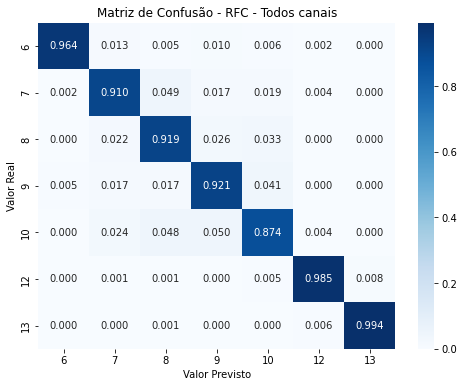

Função MatrizConfusao concluída!


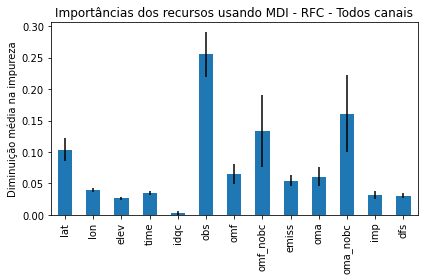

Função FeatureImportance concluída!


In [14]:
tipo = "RFC - Todos canais"

MatrizConfusao(y_test, y_pred, classes, tipo)

FeatureImportance(modelo, atributos, tipo)

In [15]:
# Lista de atributos a serem usados para treinamento
atributos = ['lat','lon','elev','time','iuse',
             'idqc','inverr','oer','obs','omf','omf_nobc',
             'emiss','oma','oma_nobc','imp','dfs']

# Define as classes do target discretizado para uso posterior
classes = ['6','7','8','9','10','12','13']

X = df_concatenado2[atributos]
y = df_concatenado2['nchan']

In [16]:
X_train, X_test, y_train, y_test, modelo, y_pred, y_score = train_test_pred_score_RFC(X, y)

Treino e Teste prontos
Modelo treinado!
Previsões feitas!
Previsões de probabilidade feitas!
Função train_test_pred_score_RFC concluída!


In [17]:
# Gera e imprime o relatório de classificação, que inclui métricas como precisão, recall e F1-score
relatorio_classificacao = classification_report(y_test, y_pred)
print("\nRelatório de Classificação:")
print(relatorio_classificacao)



Relatório de Classificação:
              precision    recall  f1-score   support

         6.0       1.00      1.00      1.00      2256
         7.0       1.00      1.00      1.00      2804
         8.0       1.00      1.00      1.00      2847
         9.0       1.00      1.00      1.00      2843
        10.0       1.00      1.00      1.00      2828
        12.0       1.00      1.00      1.00      2741
        13.0       1.00      1.00      1.00      2776

    accuracy                           1.00     19095
   macro avg       1.00      1.00      1.00     19095
weighted avg       1.00      1.00      1.00     19095



Matriz de Confusão para RFC - Todos canais:
[[2256    0    0    0    0    0    0]
 [   0 2804    0    0    0    0    0]
 [   0    2 2845    0    0    0    0]
 [   0    0    0 2843    0    0    0]
 [   0    0    0    0 2828    0    0]
 [   0    0    0    0    0 2741    0]
 [   0    0    0    0    0    0 2776]]


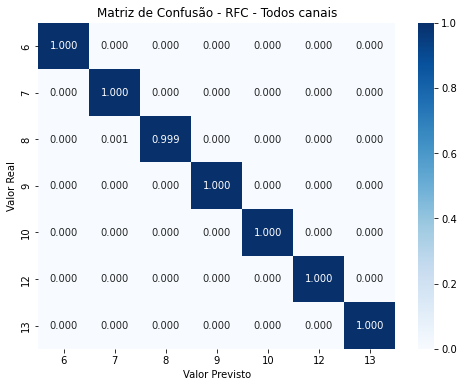

Função MatrizConfusao concluída!


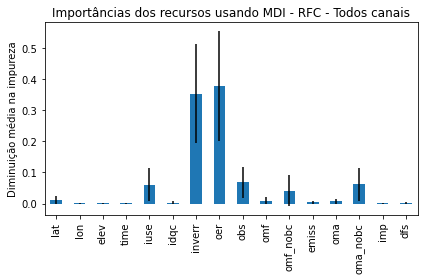

Função FeatureImportance concluída!


In [18]:
tipo = "RFC - Todos canais"

MatrizConfusao(y_test, y_pred, classes, tipo)

FeatureImportance(modelo, atributos, tipo)

In [19]:
print(y_pred)

[ 8.  8. 13. ...  6.  7. 12.]


In [20]:
# Lista de atributos a serem usados para treinamento
atributos = ['lat','lon','elev','time','iuse',
             'idqc','inverr','oer','obs','omf','omf_nobc',
             'emiss','oma','oma_nobc','imp','dfs']

# Define as classes do target discretizado para uso posterior
classes = [6.0,7.0,8.0,9.0,10.0,12.0,13.0]

X = df_concatenado2[atributos]
y = df_concatenado2['nchan']

X_train, X_test, y_train, y_test, modelo, y_pred, y_score = train_test_pred_score_RFC(X, y)

# Avaliar a precisão do modelo
accuracy = accuracy_score(y_test, y_pred)
print("Acurácia do modelo:", accuracy)

# Calcular a importância das classes do atributo 'nchan' em relação a cada outro atributo
class_importances = {}

for channel_class in classes:
    # Selecionar exemplos apenas para a classe atual
    X_class = X_test[y_test == channel_class]
    
    # Calcular a importância média de cada atributo para a classe atual
    class_importances[channel_class] = X_class.mean(axis=0)

# Converter o dicionário em DataFrame para facilitar a visualização
class_importances_df = pd.DataFrame(class_importances).T
print("\nImportância das classes do atributo 'nchan' em relação a cada outro atributo:")
print(class_importances_df)

Treino e Teste prontos
Modelo treinado!
Previsões feitas!
Previsões de probabilidade feitas!
Função train_test_pred_score_RFC concluída!
Acurácia do modelo: 0.9998952605394082

Importância das classes do atributo 'nchan' em relação a cada outro atributo:
           lat         lon        elev      time  iuse      idqc    inverr  \
6.0  -8.556856  184.091034  205.977081 -0.400240  -1.0 -4.435284  3.902152   
7.0  -0.060532  186.592789  265.091888 -0.428834   1.0  0.004280  3.989907   
8.0  -0.907617  183.634399  263.427185 -0.414125   1.0  0.005269  3.629978   
9.0  -1.502541  185.834930  267.319763 -0.429501   1.0  0.003166  2.938183   
10.0 -1.128801  187.098831  257.319397 -0.458713   1.0  0.001061  2.499114   
12.0 -1.827319  182.258713  286.147064 -0.415909   1.0  0.001094  0.999445   
13.0 -2.664406  185.353165  279.030884 -0.478431   1.0  0.000000  0.666069   

           oer         obs       omf  omf_nobc     emiss       oma  oma_nobc  \
6.0   0.234166  232.938889  0.042923 -1.